# Module 3 Final Project Submission

* Student name: THOMAS WHIPPLE
* Student pace: PART TIME
* Scheduled project review date/time: FRIDAY, 1/24/2020, 12pm
* Instructor name: ABHINEET KULKARNI
* Blog post URL: https://medium.com/p/2e64ae75da59/edit


# Northwinds Statistical Analysis Introduction
The goal of this project is to query the Northwinds database to get the data needed to perform FOUR statistical analyses and hypothesis tests to generate analytical insights that can be of value to the company.


# Experiment 1 - Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In [62]:
# Import libraries
import pandas as pd
import sqlite3
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.stats.power import  tt_ind_solve_power
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [4]:
# Load connection and cursor
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

# Join the tables OrderDetails and Products
cur.execute("""SELECT Discount, Quantity 
               FROM OrderDetail
               JOIN Product
               USING(UnitPrice)
               ;""")
df1 = pd.DataFrame(cur.fetchall())
df1.columns = [x[0] for x in cur.description]
df1.head()

,Discount,Quantity
0,0.0,12
1,0.0,12
2,0.0,12
3,0.0,12
4,0.0,5


In [5]:
# Look further into the data
df1.describe()

,Discount,Quantity
count,2458.000000,2458.000000
mean,0.058035,23.815297
std,0.085474,19.473453
min,0.000000,1.000000
25%,0.000000,10.000000
50%,0.000000,20.000000
75%,0.100000,30.000000
max,0.250000,130.000000


In [6]:
# Check for any missing values
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2458 entries, 0 to 2457
Data columns (total 2 columns):
Discount    2458 non-null float64
Quantity    2458 non-null int64
dtypes: float64(1), int64(1)
memory usage: 38.5 KB


In [7]:
# Look at the different types of discounts
df1.Discount.value_counts()

0.00    1497
0.05     209
0.20     198
0.25     191
0.15     184
0.10     170
0.03       3
0.01       2
0.02       2
0.04       1
0.06       1
Name: Discount, dtype: int64

In [8]:
# Determine the mu for all the sales without a discount
Without_Discount = df1[df1['Discount'] == 0]
Without_Discount.describe()

,Discount,Quantity
count,1497.0,1497.000000
mean,0.0,21.851035
std,0.0,17.655569
min,0.0,1.000000
25%,0.0,10.000000
50%,0.0,20.000000
75%,0.0,30.000000
max,0.0,130.000000


In [9]:
# Determine the mu for all the sales with a discount
With_Discount = df1[df1['Discount'] > 0]
With_Discount.describe()

,Discount,Quantity
count,961.000000,961.000000
mean,0.148439,26.875130
std,0.072558,21.665713
min,0.010000,1.000000
25%,0.100000,12.000000
50%,0.150000,20.000000
75%,0.200000,35.000000
max,0.250000,130.000000


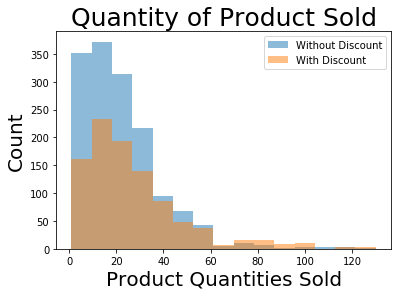

In [10]:
# Create an overlapping histogram to check for Normality
from matplotlib import pyplot
pyplot.hist(Without_Discount.Quantity, bins=15, alpha=0.5, label='Without Discount')
pyplot.hist(With_Discount.Quantity, bins=15, alpha=0.5, label='With Discount')
pyplot.legend(loc='upper right')
pyplot.ylabel("Count",fontsize=20)
pyplot.xlabel("Product Quantities Sold", fontsize=20)
pyplot.title('Quantity of Product Sold', fontsize=25)
pyplot.show()

In [103]:
# Check for variance - Homoscedasticity 
stats.levene(With_Discount.Quantity, Without_Discount.Quantity, center = 'mean')

LeveneResult(statistic=31.51852934016247, pvalue=2.197590411791746e-08)

In [11]:
# I notice that while there are more products sold without discount, both graphs look normal.

## The Null Hypothesis, $H_0$
The Null Hypothesis for Experiment 1 is that a discount will have no effect on the quantity of sales. $H_0$
#### mu = 21.69  (with_discount will be the same as without_discount)


## The Alternative Hypothesis, $H_1$
The Alternative Hypothesis for Experiment 1 is that discounted items will increase sales. $H_1$
#### mu > 21.69 (with_discount will be greater than without_discount)

### I plan to do a Welch test since I now have two equal sized groups and the variance of the two groups is different. I will use the welch_t test and then convert to a p-value using the code that I wrote with help from my lessons. I will use an alpha value of 0.05 in order to reject the null.

In [61]:
# I assume that the random, normal, and independent conditions are met.

In [84]:
# Function to determine Welch's t-test
def p_value_welch_ttest(a, b):

    # Calculate Welch's t statistic
    # “ddof" = Delta Degrees of Freedom
    
    t = np.abs((a.mean() - b.mean()) / (np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)))
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    
    # Calculate the Degrees of Freedom
    
    df = ((s1/len(a) + s2/len(b))**2)  /  ((s1/ (len(a)))**2/(len(a) - 1) + (s2/ len(b))**2/(len(b) - 1))
    
    # Calculate the "p-value"
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    return "p-value:", p


In [85]:
# Determine the t-score and the degrees of freedom from Welch's T-test
p = p_value_welch_ttest(With_Discount.Quantity, Without_Discount.Quantity)
p

('p-value:', 1.06517838993625e-09)

In [45]:
# My p-value is less than my alpha value
# 0.000000001065 < 0.05

In [ ]:
# Now I will try to validate my answer, starting with Effect size and then Power.

In [55]:
# Formula to determine Cohen's d for effect size
def cohen_d(a, b):
    
    # Calculate the difference in means divided by the square root of the pooled variance
    
    pooled_var = (len(a) * a.var() + len(b) * b.var()) / (len(a) + len(b))
    
    d = (a.mean() - b.mean()) / np.sqrt(pooled_var)
    
    return d
    

In [56]:
# Calculate Cohen's d in order to determine the power of experiment
d = cohen_d(With_Discount.Quantity, Without_Discount.Quantity)
d

0.2600093359962642

In [60]:
# Calculate the power of the experiment
power = tt_ind_solve_power(effect_size=d, alpha=0.05, nobs1=len(With_Discount.Quantity))
power

0.9999067416728048

## Conclusion:
### The power shows that this experiment has a 99% effectiveness, meaning that there is little chance the we have incorrectly rejected the null hypothesis (and made a type II error or a false negative). Therefore, orders with a discount are more likely to increase sales.

### According to my results, the p-value is small enough that I can safely reject the null - This means that there is enough evidence to state that the sales will be larger with the discounted group. You can also see in the histograph above where dicounted and non-discounted orders overlap that the discounted orders have much higher count numbers that further states that they are more likely to sell more.


# Experiment 2 - Which regions had the biggest orders and the most sales?

In [129]:
# Load connection and cursor
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

# Join the tables OrderDetails and Order
cur.execute("""SELECT ShipRegion, Freight, Quantity, UnitPrice, Discount 
               FROM OrderDetail
               JOIN "Order"
               ;""")
df2 = pd.DataFrame(cur.fetchall())
df2.columns = [x[0] for x in cur.description]
print(len(df2))
df2.head(5)

1788650


,ShipRegion,Freight,Quantity,UnitPrice,Discount
0,Western Europe,32.38,12,14.0,0.0
1,Western Europe,11.61,12,14.0,0.0
2,South America,65.83,12,14.0,0.0
3,Western Europe,41.34,12,14.0,0.0
4,Western Europe,51.30,12,14.0,0.0


In [130]:
# Take a look at ShipRegion
df2.ShipRegion.value_counts()

Western Europe     594780
North America      327560
South America      312475
British Isles      161625
Southern Europe    137920
Northern Europe    118525
Scandinavia         60340
Central America     60340
Eastern Europe      15085
Name: ShipRegion, dtype: int64

In [131]:
# Create a new column called DiscountedSale to look at Quantity, UnitPrice, and Discount
df2['DiscountedSale'] = df2.apply(lambda row: (row['Quantity']*row['UnitPrice']*(1 - row['Discount'])
                                                if row['Discount'] > 0
                                                else row['Quantity']*row['UnitPrice']), axis=1)
df2.head()

,ShipRegion,Freight,Quantity,UnitPrice,Discount,DiscountedSale
0,Western Europe,32.38,12,14.0,0.0,168.0
1,Western Europe,11.61,12,14.0,0.0,168.0
2,South America,65.83,12,14.0,0.0,168.0
3,Western Europe,41.34,12,14.0,0.0,168.0
4,Western Europe,51.30,12,14.0,0.0,168.0


In [132]:
# Check a couple rows with discounts to see if it worked
df2.iloc[6640:6641]

,ShipRegion,Freight,Quantity,UnitPrice,Discount,DiscountedSale
6640,Western Europe,32.38,6,16.8,0.05,95.76


In [133]:
df2.iloc[24070:24071]

,ShipRegion,Freight,Quantity,UnitPrice,Discount,DiscountedSale
24070,Western Europe,32.38,50,15.2,0.2,608.0


In [134]:
# Simplify the dataframe
df2 = df2.drop(['Freight', 'Quantity', 'UnitPrice', 'Discount'], axis=1)
df2.head()

,ShipRegion,DiscountedSale
0,Western Europe,168.0
1,Western Europe,168.0
2,South America,168.0
3,Western Europe,168.0
4,Western Europe,168.0


In [138]:
df2.describe()

,DiscountedSale
count,1.788650e+06
mean,5.873750e+02
std,9.689996e+02
min,4.800000e+00
25%,1.470000e+02
50%,3.377500e+02
75%,6.560000e+02
max,1.581000e+04


In [139]:
df2.tail()

,ShipRegion,DiscountedSale
1788645,Central America,26.0
1788646,Northern Europe,26.0
1788647,Western Europe,26.0
1788648,Western Europe,26.0
1788649,North America,26.0


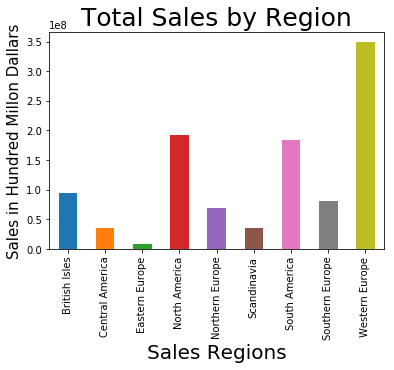

In [135]:
# Graph the sales by region
df2.groupby(['ShipRegion'])['DiscountedSale'].sum().plot(kind='bar')
plt.ylabel("Sales in Hundred Millon Dallars",fontsize=15)
plt.xlabel("Sales Regions", fontsize=20)
plt.title('Total Sales by Region', fontsize=25)
plt.show()

## The Null Hypothesis,  $H_0$
The Null Hypothesis for Experiment 2 is that ship region has no affect on total sales.
#### mu for each region is the same

## The Alternative Hypothesis,  $H_1$ ¶
The Alternative Hypothesis for Experiment 2 is that different regions have greater or lesser sales than others.

### I plan to do an ANOVA test here in order to look at the different sales regions and use an alpha value of 0.05.

In [144]:
# ANOVA test
formula = 'DiscountedSale ~ C(ShipRegion)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                     sum_sq         df             F  PR(>F)
C(ShipRegion)  2.848638e-14        8.0  3.792260e-21     1.0
Residual       1.679470e+12  1788641.0           NaN     NaN


## Conclusion
### Obviously my test has an error somewhere. The p-value of 1.0 is not correct. As you can see from the bar graph of different regional sales, there are a few regions that outperform the rest. This is true of both total discounted sales as well as quantity of sales. I attempted to break the regions up into fewer groups but the ANOVA test didn't respond. I also attempted to perform a 'groupby' in order to simplify the Discounted Sales column but again, the ANOVA test wouldn't work.

# Experiment 3 - Does unit price affect quantity of order?


In [104]:
# Load connection and cursor
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

# Join the tables OrderDetails and Products
cur.execute("""SELECT UnitPrice, Quantity
               FROM Product
               JOIN OrderDetail
               Using(UnitPrice)
               ;""")
df3 = pd.DataFrame(cur.fetchall())
df3.columns = [x[0] for x in cur.description]
print(len(df3))
df3.head()

2458


,UnitPrice,Quantity
0,18.0,2
1,18.0,2
2,18.0,2
3,18.0,2
4,18.0,3


In [105]:
# Look more closely at the data
df3.describe()

,UnitPrice,Quantity
count,2458.000000,2458.000000
mean,23.460460,23.815297
std,25.372515,19.473453
min,2.500000,1.000000
25%,12.500000,10.000000
50%,18.000000,20.000000
75%,25.890000,30.000000
max,263.500000,130.000000


In [106]:
# There are many, many different prices obviously, but a few tend to make up half of the sales
df3.UnitPrice.value_counts().head()

18.0    408
14.0    224
10.0    213
12.5    110
19.0    106
Name: UnitPrice, dtype: int64

In [107]:
# Determine the mu for the sales greater than the mean unit price
Expensive = df3[df3['UnitPrice'] > df3.UnitPrice.mean()]
Expensive.describe()

,UnitPrice,Quantity
count,657.000000,657.000000
mean,48.125053,24.184170
std,39.011159,20.518237
min,24.000000,1.000000
25%,32.000000,10.000000
50%,38.000000,20.000000
75%,49.300000,30.000000
max,263.500000,130.000000


In [108]:
# Determine the mu for the sales less than the mean unit price
Cheap = df3[df3['UnitPrice'] < df3.UnitPrice.mean()]
Cheap.describe()

,UnitPrice,Quantity
count,1801.000000,1801.000000
mean,14.462882,23.680733
std,4.588577,19.082211
min,2.500000,1.000000
25%,10.000000,10.000000
50%,14.000000,20.000000
75%,18.000000,30.000000
max,23.250000,130.000000


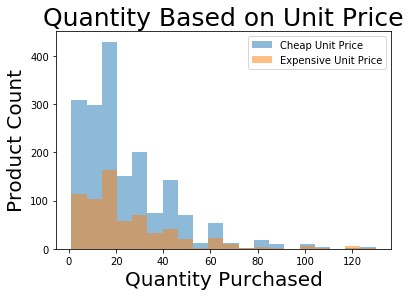

In [114]:
# Plot a histogram of the data to see if it is somewhat normal in shape.
pyplot.hist(Cheap.Quantity, bins=20, alpha=0.5, label='Cheap Unit Price')
pyplot.hist(Expensive.Quantity, bins=20, alpha=0.5, label='Expensive Unit Price')
pyplot.legend(loc='upper right')
pyplot.ylabel("Product Count",fontsize=20)
pyplot.xlabel("Quantity Purchased", fontsize=20)
pyplot.title('Quantity Based on Unit Price', fontsize=25)
pyplot.show()

In [ ]:
# I attempted to get rid of some of the outliers for these groups, both very expensive and very cheap items, but
# the results were the same.

## The Null Hypothesis,  𝐻0 
### The Null Hypothesis for Experiment 3 is that the UnitPrice of an item will have no effect on the quantity of sales.
### mu_cheap = mu_expensive

## The Alternative Hypothesis,  𝐻1 
### The Alternative Hypothesis for Experiment 3 is that cheaper items will have a greater quantity of sales.
### mu_cheap > mu_expensive

### I plan to do a Welch's test here in order to look at the different unit price categories using an alpha value of 0.05.

In [117]:
# Welch's t-test
stats.ttest_ind(Cheap.Quantity, Expensive.Quantity, equal_var = False)

Ttest_indResult(statistic=-0.5483265439443474, pvalue=0.5835794189202057)

In [118]:
# Cohen's d
d = Cohen_d(Cheap.UnitPrice, Expensive.UnitPrice)
d

-1.6382437763180844

In [120]:
# Check the power using Cohen's d and the size of the smaller group
power = tt_ind_solve_power(effect_size=d, alpha=0.05, nobs1=len(Expensive))
power

1.0

## Conclusion:
### According to the results of experiment number 3 and a p-value greater than 0.05, there was no difference between the quantity of cheap items bought and the quantity of expensive items bought. We can not reject the null. The power shows us that this experiment is valid. Even though I would assume that cheaper items would be easier to sell and perhaps more profitable for a company, this test shows that this is not the case. I also tried binning items into a few different price groups but the results were inconclusive.

# Experiment 4 - Which shipping companies are the fastest?

In [64]:
# What are the different shipping companies?
# # Load a new connection and cursor

conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

# Join some of the tables
cur.execute("""SELECT *
               FROM Shipper
               ;""")
df4Shipper = pd.DataFrame(cur.fetchall())
df4Shipper.columns = [x[0] for x in cur.description]
print(len(df4Shipper))
df4Shipper.head()

3


,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [ ]:
# I can't join 'Orders' and 'Shippers' in SQL since they do not have a common key

In [ ]:
# Create the dataframe 

In [66]:
# Load connection and cursor
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

# Join some of the tables
cur.execute("""SELECT OrderDate, ShippedDate, ShipVia, ShipRegion
               FROM 'Order'
               Order By ShipVia
               ;""")
df4 = pd.DataFrame(cur.fetchall())
df4.columns = [x[0] for x in cur.description]
print(len(df4))
df4.head()

830


,OrderDate,ShippedDate,ShipVia,ShipRegion
0,2012-07-05,2012-07-10,1,Western Europe
1,2012-07-08,2012-07-15,1,Western Europe
2,2012-07-17,2012-07-23,1,Western Europe
3,2012-07-19,2012-07-29,1,Western Europe
4,2012-07-25,2012-08-12,1,Western Europe


In [67]:
# Look at the total orders by different Shipping Companies
df4.ShipVia.value_counts()

2    326
3    255
1    249
Name: ShipVia, dtype: int64

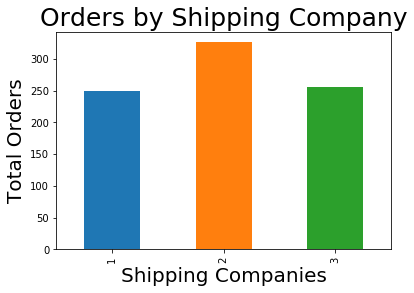

In [68]:
# Graph this data to get a visual of total orders
df4.groupby('ShipVia').size().plot(kind='bar')
plt.ylabel("Total Orders",fontsize=20)
plt.xlabel("Shipping Companies", fontsize=20)
plt.title('Orders by Shipping Company', fontsize=25)
plt.show()
plt.show()

In [69]:
# Explore the data
df4.ShippedDate.describe()

count            809
unique           387
top       2014-04-10
freq               8
Name: ShippedDate, dtype: object

In [70]:
# Look for missing data
df4.ShippedDate.tail(15)

815          None
816    2014-04-17
817    2014-04-15
818          None
819    2014-04-24
820    2014-04-23
821    2014-04-23
822    2014-04-22
823          None
824    2014-05-01
825    2014-04-30
826          None
827    2014-05-01
828          None
829          None
Name: ShippedDate, dtype: object

In [71]:
# How many null items are there?
df4.ShippedDate.isnull().sum()

21

In [72]:
# Get rid of null data and check
df4 = df4[pd.notnull(df4['ShippedDate'])]
df4.describe()

,ShipVia
count,809.000000
mean,2.004944
std,0.781896
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,3.000000


In [73]:
# Check order date just in case
df4.OrderDate.isnull().sum()

0

In [74]:
# Create new column with the number of days it took to ship out - DaysToShipOut
from datetime import datetime
df4['DaysToShipOut'] = df4.apply(lambda row: datetime.strptime(row.ShippedDate, "%Y-%m-%d") 
                                 - datetime.strptime(row.OrderDate, "%Y-%m-%d"), axis = 1)

df4.head()

,OrderDate,ShippedDate,ShipVia,ShipRegion,DaysToShipOut
0,2012-07-05,2012-07-10,1,Western Europe,5 days
1,2012-07-08,2012-07-15,1,Western Europe,7 days
2,2012-07-17,2012-07-23,1,Western Europe,6 days
3,2012-07-19,2012-07-29,1,Western Europe,10 days
4,2012-07-25,2012-08-12,1,Western Europe,18 days


In [75]:
# Datetime created an 'object' type that is going to be difficult to manipulate.
df4.DaysToShipOut.describe()

count                       809
mean     8 days 11:48:25.809641
std      6 days 20:07:42.124841
min             1 days 00:00:00
25%             4 days 00:00:00
50%             7 days 00:00:00
75%             9 days 00:00:00
max            37 days 00:00:00
Name: DaysToShipOut, dtype: object

In [76]:
# Create new column of integers - ShipOutInteger
df4['ShipOutInteger'] = df4['DaysToShipOut'].dt.days.astype('int16')
df4.head()

,OrderDate,ShippedDate,ShipVia,ShipRegion,DaysToShipOut,ShipOutInteger
0,2012-07-05,2012-07-10,1,Western Europe,5 days,5
1,2012-07-08,2012-07-15,1,Western Europe,7 days,7
2,2012-07-17,2012-07-23,1,Western Europe,6 days,6
3,2012-07-19,2012-07-29,1,Western Europe,10 days,10
4,2012-07-25,2012-08-12,1,Western Europe,18 days,18


In [77]:
# Get rid of everything I no longer need
df4 = df4.drop(['OrderDate', 'ShippedDate', 'ShipRegion', 'DaysToShipOut'], axis=1)
df4.head()

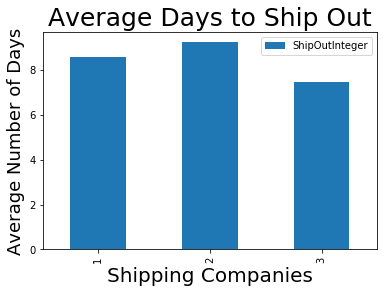

In [78]:
# Now I can find the average time it took each company to ship out the order
df4.groupby('ShipVia').mean().plot(kind='bar')
plt.ylabel("Average Number of Days",fontsize=18)
plt.xlabel("Shipping Companies", fontsize=20)
plt.title('Average Days to Ship Out', fontsize=25)
plt.show()

## The Null Hypothesis, $H_0$
The Null Hypothesis for Experiment 4 is that a there is no difference in how long the different Shipping Companies take to ship out the order.    
### mu = 8 and a half days

## The Alternative Hypothesis, $H_1$
The Alternative Hypothesis for Experiment 4 is that certain company's take longer (or not as long) as others to ship out orders. 
### mu > 8.5 days

### I plan to do an ANOVA test here in order to look at the different shipping companies using an alpha value of 0.05.

In [ ]:
# I am assuming Normality, Homogeneity of variance, and Independence

In [80]:
# The formula and column names for the OLS ANOVA test
formula = 'ShipVia ~ ShipOutInteger'
lm = ols(formula, df4).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq     df         F    PR(>F)
ShipOutInteger    1.971818    1.0  3.234207  0.072489
Residual        492.008404  807.0       NaN       NaN


In [140]:
# P-value is greater than the alpha value
# 0.072 > 0.05

In [86]:
# Code to get the effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov


In [87]:
# Determine the effect size = F
anova_table(table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
ShipOutInteger,1.971818,1.0,1.971818,3.234207,0.072489,0.003992,0.002754
Residual,492.008404,807.0,0.609676,NaN,NaN,NaN,NaN


In [92]:
F = 3.234207

In [94]:
# Calculate the power of the experiment
power = tt_ind_solve_power(effect_size=F, alpha=0.05, nobs1=249)
power

1.0

## Conclusion:
### The p-value of the ANOVA test was greater than my alpha value of 0.05 meaning that there is not enough evidence to reject the null hypothesis. This states that there really is no difference in the time it takes the shipping companies to ship out orders. If you also look at the bar graph above it shows that the three shipping companies have mean times that are very similar which also demonstrates that there is little difference between the companies.
### According to the results of the power test, I am confident that the difference in shipping companies is not statistically significant. Below, in the overlapping histogram, I broke the three different companies up into three seperate dataframes and graphed them. You can see that even with different colored labels it is hard to see where one company stands out amoungst the rest.

In [141]:
# Split the shipping companies into three seperate groups
speedy = df4[df4['ShipVia'] == 1]
united = df4[df4['ShipVia'] == 2]
federal = df4[df4['ShipVia'] == 3]

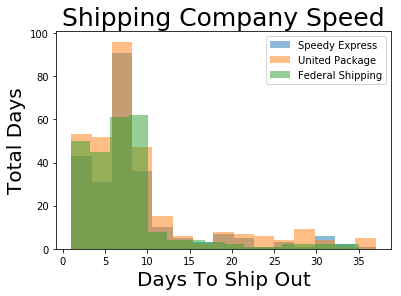

In [142]:
# Graph the histogram of the three different shipping companies
pyplot.hist(speedy.ShipOutInteger, bins=15, alpha=0.5, label='Speedy Express')
pyplot.hist(united.ShipOutInteger, bins=15, alpha=0.5, label='United Package')
pyplot.hist(federal.ShipOutInteger, bins=15, alpha=0.5, label='Federal Shipping')
pyplot.legend(loc='upper right')
pyplot.ylabel("Total Days",fontsize=20)
pyplot.xlabel("Days To Ship Out", fontsize=20)
pyplot.title('Shipping Company Speed', fontsize=25)
pyplot.show()

## Summary
### Discounted sales seemed to be the greatest factor when looking at total quantity. Certainly some discounts were more affective than others but this study did not have enough time to be more specific. Unit Price was found to be not as important on total quantity. While it seems plausible for more expensive items to be less marketable, the results showed that this was not the case. The Sales Region appears to be important but results could not be validated. This was due either to having too many regions or for the great sales variance in different regions. Furthermore, the Shipping Company proved to be a minor detail with little significance. Either the mean difference in time to ship out orders was minimal or the overall number of orders and variance makes this aspect of less a concern.

## Future Work
### Obviously I would like to review different discounts and determine which values bring in the most orders - but I would also like to have a control group were there are no discounts offered. Perhaps the money lost on discounts is made up for with additional sales. It would be helpful to have more information on the actual cost of items to be able to compare specific unit prices, markup values, and overall net profit. With Sales Region I recommend focusing on the countries with the least number of total orders. Again, using a control group that receives no additional sales support, marketing, or increased product push might allow for some curious data that would help focus on the weaker sales regions.  Lastly, knowing when a product was delivered as well as any specifics on the quality of the delivery, packaging, and distances travelled to destinations might offer more information of how the specific shipping companies are doing overall.